In [7]:
# vou assumir q a secao ja existe
import os
from legacy.atributos import Atributos
secao = Atributos(os.path.join('data/existe/CL3822_maior.sgy'), resolucao = 25, deltaz = [9955, 2000])
secao.extent = [1, secao.X.shape[0] * secao.resolucao, 9955, 2000]

# Escolha de features

In [1]:
import ipywidgets as widgets
k_param = widgets.IntSlider(
    value=4,
    min=2,
    max=100,
    step=1,
    description='Max depth:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
lista = widgets.SelectMultiple(
    options=[('Amplitude sísmica', 'X'), 
             ('Envelope', 'envelope'), ('Fase', 'fase'), ('Frequência', 'freq'), ('Sweetness', 'sweetness'), 
             ('RMS', 'rms'), ('TecVA', 'tecva'), 
             ('Semblance de alta resolução', 'semblance'), ('Sobel', 'sobel'), ('Marfurt', 'marfurt')],
    value=['X'],
    #rows=10,
    description='Atributos:',
    disabled=False
)

In [2]:
items = [lista, k_param]
processo = widgets.Box(children = items)
display(processo)

Box(children=(SelectMultiple(description='Atributos:', index=(0,), options=(('Amplitude sísmica', 'X'), ('Enve…

# Carregue outras features

In [ ]:
import os
upload = widgets.FileUpload(accept='.sgy', multiple=True,)
display(upload)

FileUpload(value=(), accept='.sgy', description='Upload', multiple=True)

# Carregue as labels

In [10]:
uploady = widgets.FileUpload(accept='.csv', multiple=True,)
display(uploady)

FileUpload(value=(), accept='.csv', description='Upload', multiple=True)

# Backend

In [20]:
import segyio
import numpy as np
import pickle

from sklearn.ensemble import RandomForestClassifier

from legacy.atributos import Atributos
from legacy.superficie import Superficie
from legacy.utils import plot, concatenate, subplot, segmenta

In [5]:
from scipy.ndimage import zoom

def resample(obj, target):
    crop_vel(obj, target)
    zoom_factors = (
        obj.X.shape[0] / target.shape[0],
        obj.X.shape[1] / target.shape[1]
    )
    return zoom(target, zoom_factors, order=3)

def crop_vel(obj, target):
    extent = [2000, 9955]
    h = int(target.shape[1] * extent[0] / extent[1])
    target = target[:, h:]

In [17]:
barravelha = Superficie('data/' + uploady.value[0].name, shape = [1950, 1710], offsets = [2100, 3285])
camboriu = Superficie('data/' + uploady.value[1].name, shape = [1950, 1710], offsets = [2100, 3285])

In [18]:
secao.barravelha = barravelha.line(i = 3822 - 2100, inline = 1, offset = True)
secao.camboriu = camboriu.line(i = 3822 - 2100, inline = 1, offset = True)
segmenta(secao)

In [ ]:
new = []
for item in upload.value:
    # print(item)
    new.append(segyio.tools.cube('data/' + item.name)[0, :, :])
    if new[-1].shape != secao.X.shape:
        new[-1] = resample(secao, new[-1])

In [ ]:
secao._complexo()
secao._logaritmo()
secao._coherence()
secao._tecva()
secao._soterramento(marambaia = False)

In [19]:
k = k_param.value
obj = secao

X_trn = concatenate([getattr(secao, atr) for atr in lista.value] + new)
Y_trn = obj.segmentado.ravel()

rf = RandomForestClassifier(max_depth = k_param.value, )
rf.fit(X_trn, Y_trn);

In [21]:
secao.yhat = rf.predict(X_trn).reshape(secao.X.shape)

# Resultado

In [22]:
with open('output/model_rf.pkl', 'wb') as out:
    pickle.dump(rf, out)

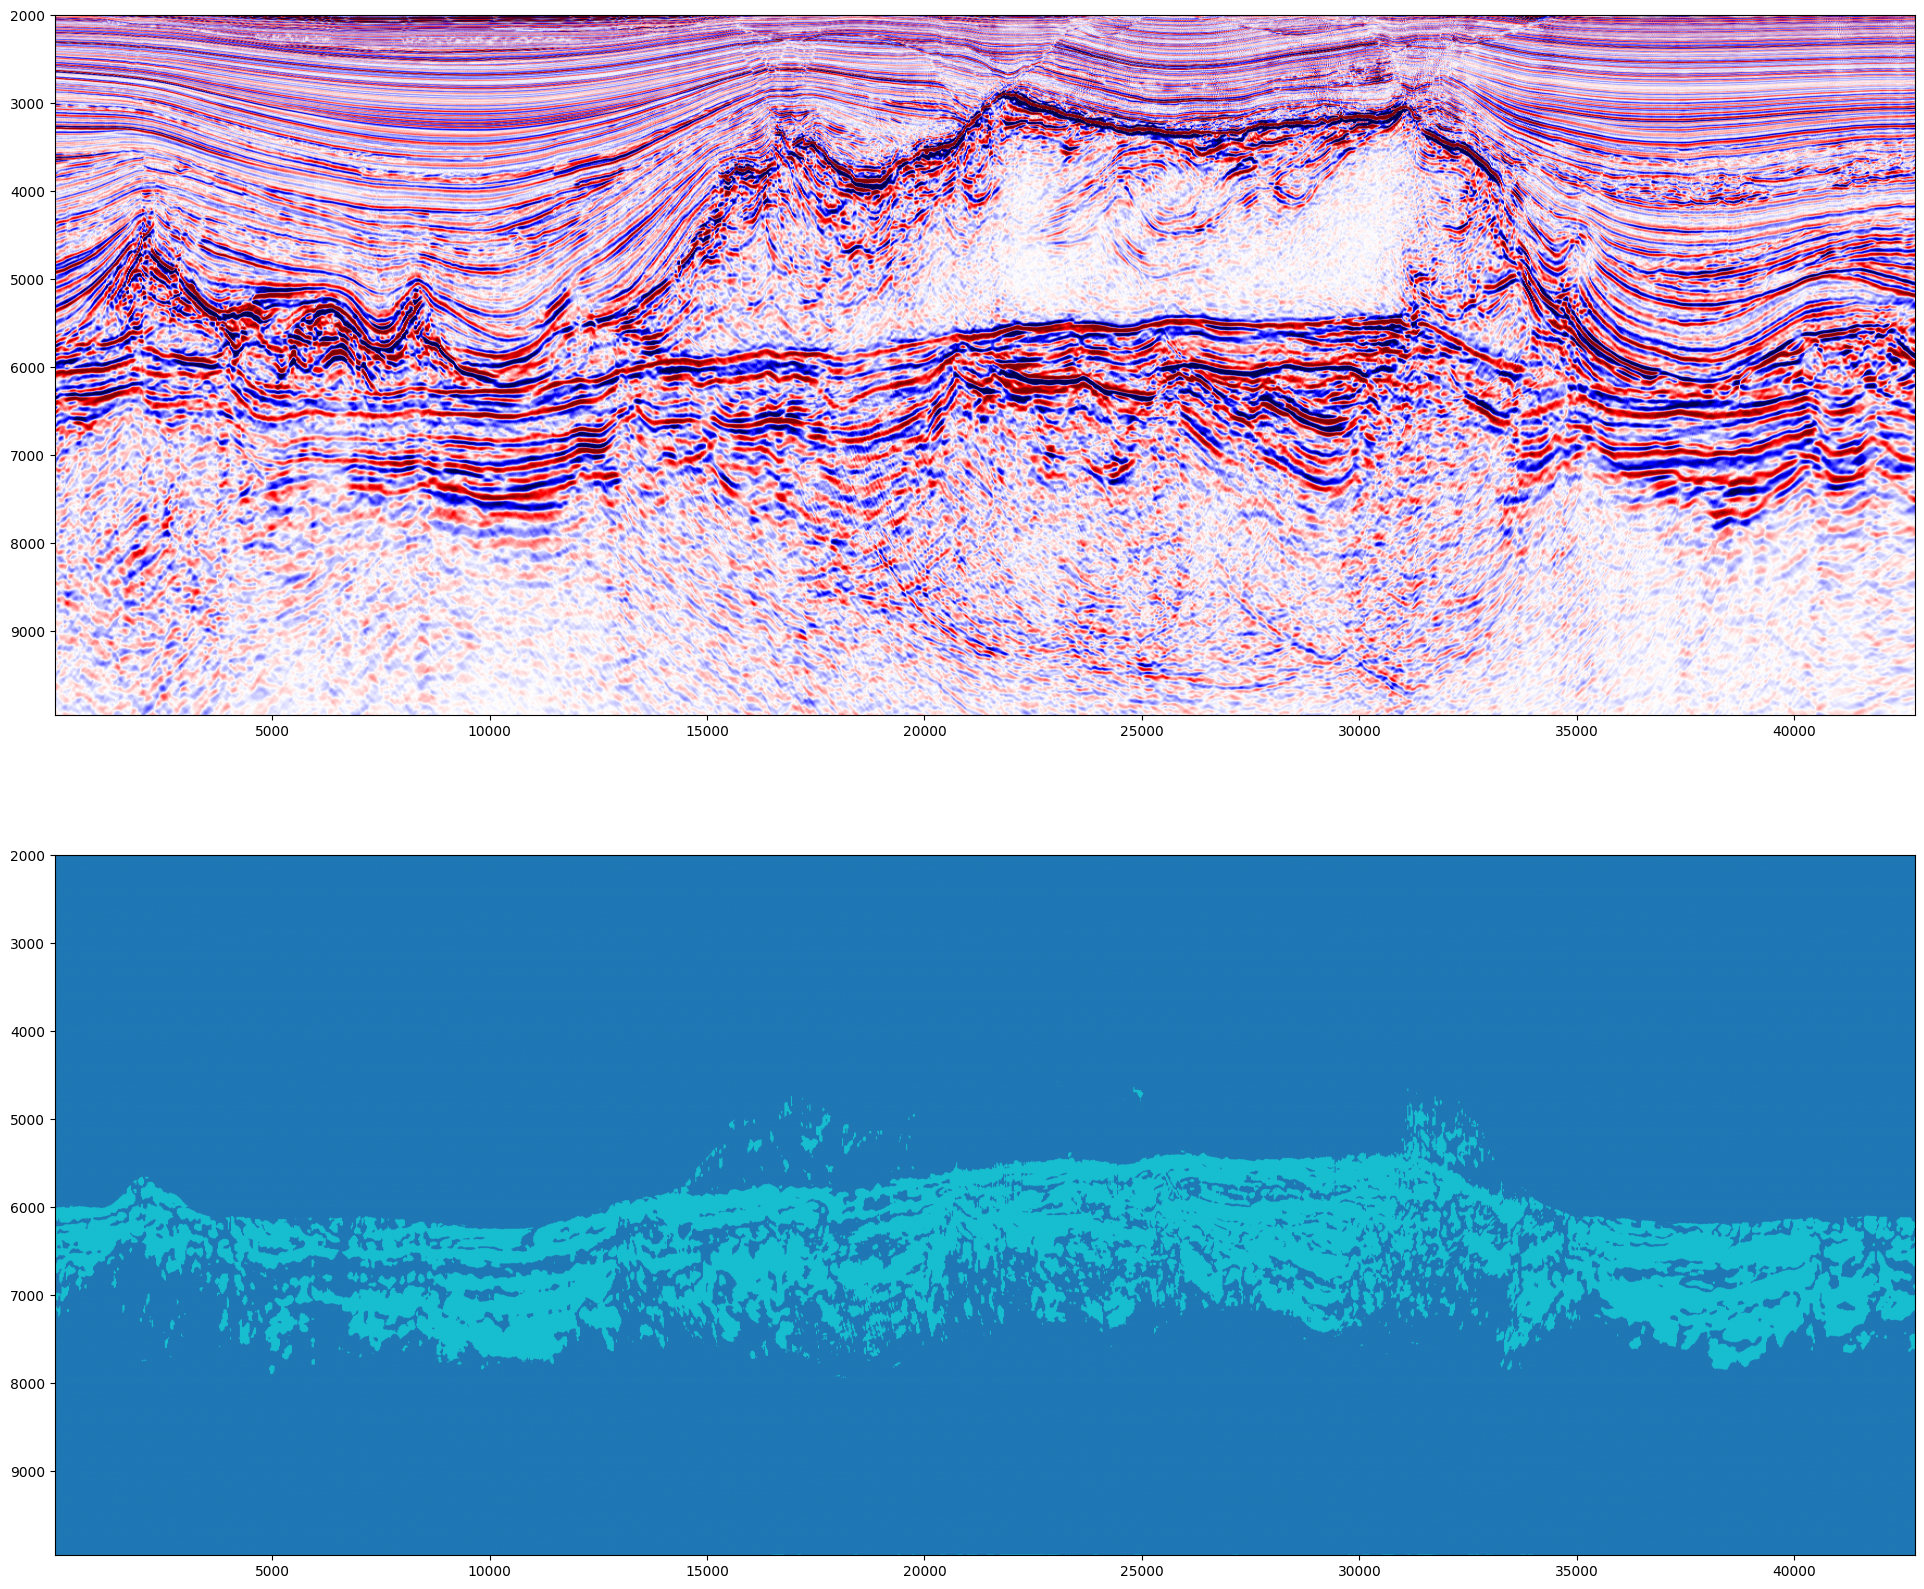

In [23]:
subplot(secao, [secao.X, secao.yhat], colors = ['seismic', 'tab10'], percentils = [(1, 99), (0, 100)])

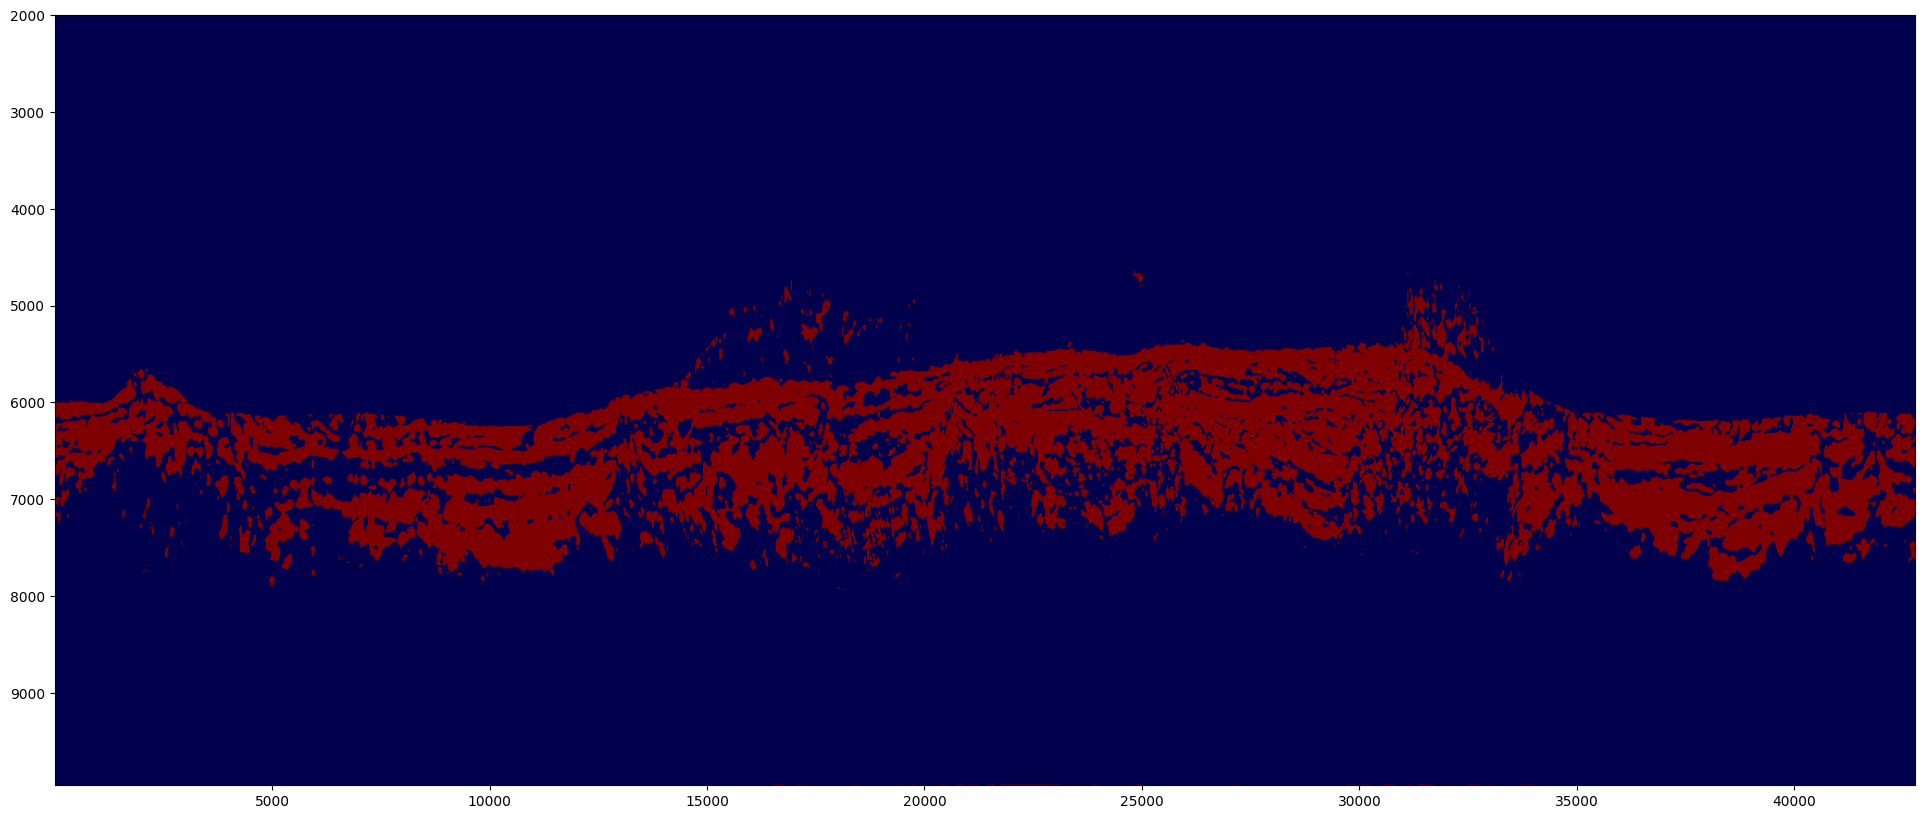

In [24]:
plot(secao, secao.yhat)